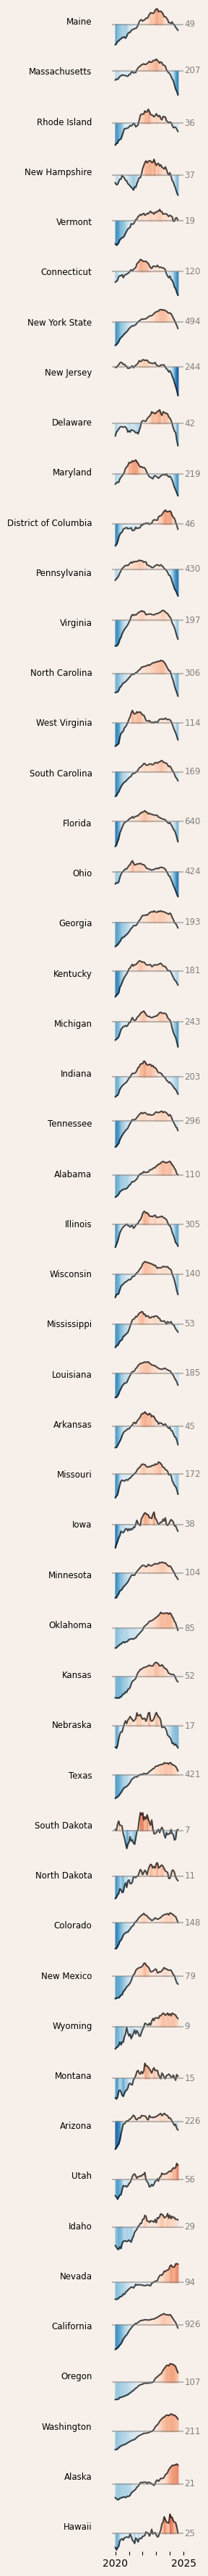

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Load the data
merged_df = pd.read_csv('merged_data.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])  # Ensure 'Date' is a datetime object

# Filter for January 2020 onwards
merged_df = merged_df[merged_df['Date'] >= '2020-01-01']

# Load state centroid data with longitude (mock data structure for this example)
state_centroids = {
    'Alabama': -86.9023, 'Alaska': -152.4044, 'Arizona': -111.0937, 'Arkansas': -92.2880,
    'California': -119.4179, 'Colorado': -105.5506, 'Connecticut': -72.6970, 'Delaware': -75.5277,
    'Florida': -81.5158, 'Georgia': -83.5002, 'Hawaii': -155.5828, 'Idaho': -114.7420,
    'Illinois': -89.3985, 'Indiana': -86.1349, 'Iowa': -93.6091, 'Kansas': -98.4842,
    'Kentucky': -84.2700, 'Louisiana': -91.9623, 'Maine': -69.4455, 'Maryland': -76.6413,
    'Massachusetts': -71.3824, 'Michigan': -85.6024, 'Minnesota': -93.9002, 'Mississippi': -89.6787,
    'Missouri': -92.6179, 'Montana': -110.3626, 'Nebraska': -99.9018, 'Nevada': -116.4194,
    'New Hampshire': -71.5724, 'New Jersey': -74.4057, 'New Mexico': -106.0181, 'New York State': -74.006,
    'North Carolina': -79.0193, 'North Dakota': -100.4659, 'Ohio': -82.7937, 'Oklahoma': -97.5211,
    'Oregon': -120.5542, 'Pennsylvania': -77.1945, 'Rhode Island': -71.4774, 'South Carolina': -81.1637,
    'South Dakota': -99.9018, 'Tennessee': -86.5804, 'Texas': -99.9018, 'Utah': -111.9507,
    'Vermont': -72.5778, 'Virginia': -78.6569, 'Washington': -120.7401, 'West Virginia': -80.7125,
    'Wisconsin': -89.6165, 'Wyoming': -107.3025, 'District of Columbia': -77.033
}

# Add longitude information to merged_df
merged_df['Longitude'] = merged_df['State Name'].map(state_centroids)

# Calculate z-scores for 'Predicted Value' grouped by state
merged_df['zscore_predicted_value'] = merged_df.groupby('State Name')['Predicted Value'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# Calculate average Predicted Value for the entire time period by state
state_avg_predicted_value = merged_df.groupby('State Name')['Predicted Value'].mean()

# Sort states by longitude in descending order (east at the top), excluding "New York"
states_sorted_by_long = merged_df[merged_df['State Name'] != "New York"] \
    [['State Name', 'Longitude']].drop_duplicates() \
    .sort_values(by='Longitude', ascending=False)['State Name']

# Prepare the data for sparklines
months = pd.date_range(merged_df['Date'].min(), merged_df['Date'].max(), freq='MS')
fig, axes = plt.subplots(len(states_sorted_by_long), 1, figsize=(3, len(states_sorted_by_long) * 0.7), sharex=True)  # Adjusted width (narrower)
fig.patch.set_facecolor('#f7f0ea')  # Set background color for the entire figure area

# Generate sparklines for each state
for i, state in enumerate(states_sorted_by_long):
    ax = axes[i] if len(states_sorted_by_long) > 1 else axes  # Single subplot vs multiple
    ax.set_facecolor('#f7f0ea')  # Set background color for each subplot
    state_data = merged_df[merged_df['State Name'] == state]

    # Normalize z-scores to use with colormap
    norm = plt.Normalize(vmin=-4, vmax=4)  # Assuming z-scores range from -4 to 4
    cmap = plt.get_cmap('RdBu_r')  # Blue-Red colormap

    # Add fill between shading and trace line with color
    ax.plot(
        state_data['Date'],
        state_data['zscore_predicted_value'],
        color='black', linewidth=1.5, alpha=0.7  # Thicker black trace line
    )

    for j in range(len(state_data) - 1):
        ax.fill_between(
            state_data['Date'].iloc[j:j+2],
            0,
            state_data['zscore_predicted_value'].iloc[j:j+2],
            color=cmap(norm(state_data['zscore_predicted_value'].iloc[j]))
        )

    # Add average Predicted Value scaled down by 12 near the end of the state's line
    if state in state_avg_predicted_value:
        predicted_value_scaled = state_avg_predicted_value[state] / 12

        ax.text(
            merged_df['Date'].max() + pd.Timedelta(days=180), 0,  # Move further to the right
            f'{predicted_value_scaled:,.0f}',
            color='grey', fontsize=8.5, ha='left', va='center'  # Fixed font size to 8.5
        )

    ax.axhline(c='grey', alpha=0.5)  # Horizontal reference line

    # Remove borders and labels
    ax.set_yticks([])
    ax.set_ylabel(state, rotation=0, fontsize=8.5, labelpad=20, ha='right')  
    plt.setp(ax.spines.values(), visible=False)

    # Remove x-axis ticks for all but the last plot
    if i < len(states_sorted_by_long) - 1:
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust x-axis only for the last subplot
if len(axes) > 1:
    plt.setp(axes[-1].get_xticklabels(), visible=True)
    axes[-1].tick_params(axis='x', rotation=0)

# Set custom tick labels for the bottom plot
full_tick_locs = pd.date_range('2020-01-01', '2025-01-01', freq='YS')
axes[-1].set_xticks(full_tick_locs)
tick_labels = ["2020" if date.year == 2020 else "2025" if date.year == 2025 else "" for date in full_tick_locs]
axes[-1].set_xticklabels(tick_labels)

# Define output path and ensure directory exists
output_path = 'state_sparklines.png'
plt.tight_layout()
plt.savefig(output_path, dpi=500)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a0b131bb-b3d4-45d7-9b08-dfa85260ae4a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>